### **Import Libraries**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.layers import Input, Dense, Dropout, Activation
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.regularizers import l2
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.layers import concatenate
%matplotlib inline  
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.python.keras.models import model_from_json

### **Generate serial userID and itemID**

In [ ]:
# ratings = pd.read_csv('data/cleaned/purchase_play_rating.csv')
# ratings.head(5)

In [ ]:
# users = ratings['user'].unique()
# len(users)

In [ ]:
# for index, row in ratings.iterrows():
#     for i in range(12393):
#         if row['user'] == users[i]:
#             ratings.loc[index, 'userID'] = i
#             break;
#     print(index)

In [ ]:
# items = ratings['game'].unique()
# len(items)

In [ ]:
# for index, row in ratings.iterrows():
#     for i in range(5155):
#         if row['game'] == items[i]:
#             ratings.loc[index, 'itemID'] = i
#             break;
#     print(index)

In [ ]:
# ratings.to_csv('data/cleaned/user_game_rating.csv', index=False)

### **Loading Data**

In [ ]:
data = pd.read_csv('data/cleaned/user_game_rating.csv')
data.head(5)

,user,game,hrs,purchase,play,rating,userID,itemID
0,5250,Alien Swarm,294.0,1,1,4,0.0,0.0
1,5250,Cities Skylines,8640.0,1,1,5,0.0,1.0
2,5250,Counter-Strike,0.0,1,0,1,0.0,2.0
3,5250,Counter-Strike Source,0.0,1,0,1,0.0,3.0
4,5250,Day of Defeat,0.0,1,0,1,0.0,4.0


In [ ]:
# store list of games
items = data['game'].unique()

In [ ]:
ratings = data.filter(['userID','itemID','rating'], axis=1)
ratings.head(5)

,userID,itemID,rating
0,0.0,0.0,4
1,0.0,1.0,5
2,0.0,2.0,1
3,0.0,3.0,1
4,0.0,4.0,1


In [ ]:
# convert rating tye to int
ratings['userID'] = ratings['userID'].astype(int)
ratings['itemID'] = ratings['itemID'].astype(int)
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128804 entries, 0 to 128803
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   userID  128804 non-null  int64
 1   itemID  128804 non-null  int64
 2   rating  128804 non-null  int64
dtypes: int64(3)
memory usage: 2.9 MB


In [ ]:
# calculate total number of unique users and games
num_items = len(ratings['itemID'].unique())
num_users = len(ratings['userID'].unique())

### **Split data into train, test and validation datasets**

In [ ]:
train_df, test_df = train_test_split(ratings,test_size=0.1)

In [ ]:
train_df.head(5)

,userID,itemID,rating
128124,12005,878,2
74730,3335,76,2
38527,1368,48,2
124444,10785,19,2
30455,1078,1107,1


In [ ]:
train_df, validate_df = train_test_split(train_df,
                                     test_size=0.1,)

### **Data Pre-processing**

In [ ]:
def dataPreprocessor(rating_df, num_users, num_items, init_value=0, average=False):
    """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items
            
        OUTPUT:
            matrix: 2D numpy array. 
    """
    if average:
      matrix = np.full((num_users, num_items), 0.0)
      for (_, userID, itemID, rating) in rating_df.itertuples():
        matrix[userID, itemID] = rating
      avergae = np.true_divide(matrix.sum(1), np.maximum((matrix!=0).sum(1), 1))
      inds = np.where(matrix == 0)
      matrix[inds] = np.take(avergae, inds[0])
      
    else:
      matrix = np.full((num_users, num_items), init_value)
      for (_, userID, itemID, rating) in rating_df.itertuples():
        matrix[userID, itemID] = rating

    return matrix

In [ ]:
# Creating a sparse pivot table with users in rows and items in columns
users_items_matrix_train_zero = dataPreprocessor(train_df, num_users, num_items, 0)
users_items_matrix_validate = dataPreprocessor(validate_df, num_users, num_items, 0)
users_items_matrix_test = dataPreprocessor(test_df, num_users, num_items, 0)

In [ ]:
users_items_matrix_train_average = dataPreprocessor(train_df, num_users, num_items, average=True)

### **Different Evaluation Metrics and Visualizations**

In [ ]:
def show_error(history, skip):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(np.arange(skip, len(loss), 1), loss[skip:])
    plt.plot(np.arange(skip, len(loss), 1), val_loss[skip:])
    plt.title('model train vs validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()

In [ ]:
def show_rmse(history, skip):
    rmse = history.history['masked_rmse_clip']
    val_rmse = history.history['val_masked_rmse_clip']
    plt.plot(np.arange(skip, len(rmse), 1), rmse[skip:])
    plt.plot(np.arange(skip, len(val_rmse), 1), val_rmse[skip:])
    plt.title('model train vs validation masked_rmse')
    plt.ylabel('rmse')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()

In [ ]:
def masked_mse(y_true, y_pred):
        # masked function
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1)
        return masked_mse

In [ ]:
def masked_rmse(y_true, y_pred):
        # masked function
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sqrt(K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1))
        return masked_mse

In [ ]:
def masked_rmse_clip(y_true, y_pred):
        # masked function
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        y_pred = K.clip(y_pred, 1, 5)
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sqrt(K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1))
        return masked_mse

### **Build a Model**

In [ ]:
def Deep_AE_model(X, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode, side_infor_size=0):
    '''
    Build Deep AE for CF
        INPUT: 
            X: #_user X #_item matrix
            layers: List, each element is the number of neuron for a layer
            reg: L2 regularization parameter
            activation: activation function for all dense layer except the last
            last_activation: activation function for the last dense layer
            dropout: dropout rate
            regularizer_encode: regularizer for encoder
            regularizer_decode: regularizer for decoder
            side_infor_size: size of the one hot encoding side information
        OUTPUT:
            Keras model
    '''

    # Input
    input_layer = x = Input(shape=(X.shape[1],), name='UserRating')
    
    # Encoder
    k = int(len(layers)/2)
    i = 0
    for l in layers[:k]:
      x = Dense(l, activation=activation,
                      name='EncLayer{}'.format(i), kernel_regularizer=regularizers.l2(regularizer_encode))(x)
      i = i+1
      
      
    # Latent Space
    x = Dense(layers[k], activation=activation, 
                                name='LatentSpace', kernel_regularizer=regularizers.l2(regularizer_encode))(x)
    
    # Dropout
    x = Dropout(rate = dropout)(x)
    
    # Decoder
    for l in layers[k+1:]:
      i = i-1
      x = Dense(l, activation=activation, 
                      name='DecLayer{}'.format(i), kernel_regularizer=regularizers.l2(regularizer_decode))(x)
      
    # Output
    output_layer = Dense(X.shape[1]-side_infor_size, activation=last_activation, name='UserScorePred', kernel_regularizer=regularizers.l2(regularizer_decode))(x)

    # this model maps an input to its reconstruction
    model = Model(input_layer, output_layer)

    return model


In [ ]:
# defining hyperparameters
layers = [512, 256, 128, 256, 512]
dropout = 0.2
# activation = 'sigmoid'
# last_activation = 'linear'
activation = 'selu'
last_activation = 'selu'
regularizer_encode = 0.001
regularizer_decode = 0.001

In [ ]:
tf.compat.v1.disable_eager_execution()

In [ ]:
# Build model
Deep_AE = Deep_AE_model(users_items_matrix_train_zero, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode)
Deep_AE.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse, masked_rmse_clip]) 
Deep_AE.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserRating (InputLayer)      [(None, 5155)]            0         
_________________________________________________________________
EncLayer0 (Dense)            (None, 512)               2639872   
_________________________________________________________________
EncLayer1 (Dense)            (None, 256)               131328    
_________________________________________________________________
LatentSpace (Dense)          (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
DecLayer1 (Dense)            (None, 256)               33024     
_________________________________________________________________
DecLayer0 (Dense)            (None, 512)              

In [ ]:
hist_Deep_AE = Deep_AE.fit(x=users_items_matrix_train_zero, y=users_items_matrix_train_zero,
                  epochs=100,
                  batch_size=256,
                  validation_data=[users_items_matrix_train_zero, users_items_matrix_validate], verbose=1)

Train on 12393 samples, validate on 12393 samples
Epoch 1/100
12393/12393 [==============================] - 2s 146us/sample - loss: 7.8974 - masked_rmse: 1.8761 - masked_rmse_clip: 1.4463 - val_loss: 4.1735 - val_masked_rmse: 0.6048 - val_masked_rmse_clip: 0.4775
Epoch 2/100
12393/12393 [==============================] - 2s 137us/sample - loss: 4.4080 - masked_rmse: 1.0956 - masked_rmse_clip: 0.9905 - val_loss: 3.1125 - val_masked_rmse: 0.4339 - val_masked_rmse_clip: 0.4021
Epoch 3/100
12393/12393 [==============================] - 2s 132us/sample - loss: 3.1806 - masked_rmse: 0.8172 - masked_rmse_clip: 0.7909 - val_loss: 2.7880 - val_masked_rmse: 0.3992 - val_masked_rmse_clip: 0.3768
Epoch 4/100
12393/12393 [==============================] - 2s 133us/sample - loss: 2.6917 - masked_rmse: 0.6993 - masked_rmse_clip: 0.6885 - val_loss: 2.6738 - val_masked_rmse: 0.3999 - val_masked_rmse_clip: 0.3693
Epoch 5/100
12393/12393 [==============================] - 2s 130us/sample - loss: 2.4176 

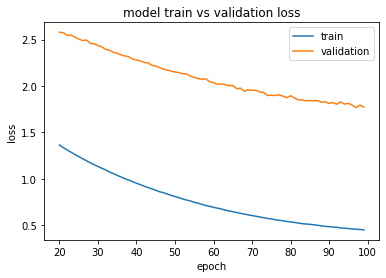

In [ ]:
show_error(hist_Deep_AE, 20)

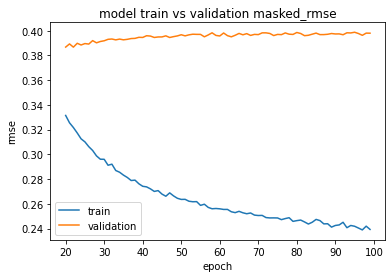

In [ ]:
show_rmse(hist_Deep_AE, 20)

In [ ]:
predict_deep = Deep_AE.predict(users_items_matrix_train_zero)

In [ ]:
test_result_deep = Deep_AE.evaluate(users_items_matrix_train_zero, users_items_matrix_test, verbose=2)

In [ ]:
test_result_deep

[2.0056809955500117, 0.57944727, 0.4479232]

In [ ]:
def save_model(model):
  # serialize weights to HDF5
  model.save_weights("model/GameAEmodel.h5")
  print("Saved model to disk")

In [ ]:
def load_model():
  loaded_model = Deep_AE_model(users_items_matrix_train_zero, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode)
  loaded_model.load_weights("model/GameAEmodel.h5")
  return loaded_model

In [ ]:
save_model(Deep_AE)

Saved model to disk


In [ ]:
# model = load_model()

In [ ]:
predictions = predict_deep

In [ ]:
predictions.shape

(12393, 5155)

### **Making Recommendations for unknown ratings**

In [ ]:
item = items.reshape(-1,1)

def getGameRecommendation(user, topN):
    index = 0
    rec= []
    user = data[data['user']==user]
    index = int(user['userID'].iloc[0])
    pred = predictions[index]
    pred = np.clip(pred, 1 , 5)    
    pred = pred.reshape(-1,1)
    rec = np.concatenate((item,pred),axis = 1)
    rec_df = pd.DataFrame(data=rec, columns=["game", "rating"])
    rec_df = rec_df.sort_values(["rating"], ascending = False)
    return rec_df[0:topN]

In [ ]:
data[data['user']==76767]

,user,game,hrs,purchase,play,rating,userID,itemID
21,76767,Age of Empires II HD Edition,786.0,1,1,4,1.0,21.0
22,76767,Alien Swarm,48.0,1,1,2,1.0,0.0
23,76767,Arma 2,0.0,1,0,1,1.0,22.0
24,76767,Arma 2 Operation Arrowhead,0.0,1,0,1,1.0,23.0
25,76767,Arma 2 Operation Arrowhead Beta (Obsolete),0.0,1,0,1,1.0,24.0
26,76767,Banished,1440.0,1,1,5,1.0,25.0
27,76767,Call of Duty Black Ops,1320.0,1,1,5,1.0,26.0
28,76767,Call of Duty Black Ops - Multiplayer,750.0,1,1,4,1.0,27.0
29,76767,Call of Duty Modern Warfare 2,3900.0,1,1,5,1.0,28.0
30,76767,Call of Duty Modern Warfare 2 - Multiplayer,9900.0,1,1,5,1.0,29.0


In [ ]:
getGameRecommendation(76767, 10)

,game,rating
752,The Escapists,5
1266,Farming Simulator 15,5
1442,Football Manager 2014,5
2174,Football Manager 2010,5
166,Divinity Original Sin,5
4213,LEGO Jurassic World,5
3900,MLB Front Office Manager,5
867,The Binding of Isaac Rebirth,4.99736
1383,Pro Evolution Soccer 2014,4.99144
120,Age of Empires III Complete Collection,4.95068


In [ ]:
data[data['user']==103360]

,user,game,hrs,purchase,play,rating,userID,itemID
139,103360,Counter-Strike,0.0,1,0,1,3.0,2.0
140,103360,Counter-Strike Condition Zero,0.0,1,0,1,3.0,111.0
141,103360,Counter-Strike Condition Zero Deleted Scenes,0.0,1,0,1,3.0,112.0
142,103360,Day of Defeat,0.0,1,0,1,3.0,4.0
143,103360,Deathmatch Classic,0.0,1,0,1,3.0,5.0
144,103360,Half-Life,0.0,1,0,1,3.0,8.0
145,103360,Half-Life Blue Shift,0.0,1,0,1,3.0,14.0
146,103360,Half-Life Opposing Force,0.0,1,0,1,3.0,15.0
147,103360,Ricochet,0.0,1,0,1,3.0,18.0
148,103360,Team Fortress Classic,0.0,1,0,1,3.0,20.0


In [ ]:
getGameRecommendation(103360, 10)

,game,rating
418,Synergy,2.91359
4213,LEGO Jurassic World,2.75891
2578,Call of Duty Black Ops III,2.67905
204,Just Cause 2 Multiplayer Mod,2.60107
1202,RollerCoaster Tycoon 3 Platinum!,2.58124
133,Battlefield Bad Company 2,2.56348
832,Grand Theft Auto V,2.51201
2783,Disciples III Reincarnation,2.49815
44,Total War ATTILA,2.49788
904,H1Z1,2.47999


In [ ]:
data[data['user']==5250]

,user,game,hrs,purchase,play,rating,userID,itemID
0,5250,Alien Swarm,294.0,1,1,4,0.0,0.0
1,5250,Cities Skylines,8640.0,1,1,5,0.0,1.0
2,5250,Counter-Strike,0.0,1,0,1,0.0,2.0
3,5250,Counter-Strike Source,0.0,1,0,1,0.0,3.0
4,5250,Day of Defeat,0.0,1,0,1,0.0,4.0
5,5250,Deathmatch Classic,0.0,1,0,1,0.0,5.0
6,5250,Deus Ex Human Revolution,3720.0,1,1,5,0.0,6.0
7,5250,Dota 2,12.0,1,1,2,0.0,7.0
8,5250,Half-Life,0.0,1,0,1,0.0,8.0
9,5250,Half-Life 2,0.0,1,0,1,0.0,9.0


In [ ]:
getGameRecommendation(5250, 10)

,game,rating
1,Cities Skylines,4.72626
44,Total War ATTILA,4.38804
740,Rocksmith 2014,4.36106
1443,Football Manager 2015,4.32717
4851,Pro Evolution Soccer 2016,4.2276
2033,The Sims(TM) 3,4.17899
104,Tropico 4,4.14317
1509,Pro Evolution Soccer 2015,4.13987
277,South Park The Stick of Truth,4.13192
1058,Farming Simulator 2013,4.12101
